In [1]:
run statistic.ipynb

('a', 1)
['adfkj']


<Figure size 640x480 with 60 Axes>

In [2]:
run io.ipynb

['b', 'c']
['b', 'c']
False
['a', 'b', 'c']
a
False

[[1 2]
 [3 4]]
[[1 2]
 [3 4]
 [5 6]]
001


('a', 1)
['adfkj']


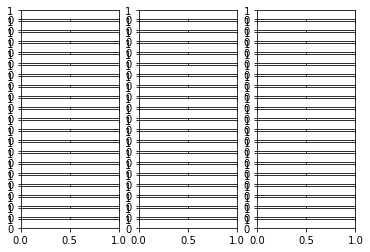

[0 1 0]


In [3]:
run data_anal.ipynb

JK
self.ave is False
Reading data...

Done reading data

Running ML...

X z's is {'mg5': ['None'], 'g8': [204, 604]}
[4]
[204]
Initfit...

ofs = 1
list of olkeys is    {'g8': {'g8.m-0.075_im-0.019938': ['m-0.075_m-0.019938.mg5']}}


pll is [4] zll is [204, 'None']
Number of data are [495, 495]
Number of data is 495
[4]
list of z [204, 'None']
spectag is ('g8.m-0.075_im-0.019938+4+None+t+0+R', 'g8.m-0.075_im-0.019938+4+None+t+0+I', 'g8.m-0.075_im-0.019938+4+None+t+1+R', 'g8.m-0.075_im-0.019938+4+None+t+1+I', 'g8.m-0.075_im-0.019938+4+None+t+2+R', 'g8.m-0.075_im-0.019938+4+None+t+2+I', 'g8.m-0.075_im-0.019938+4+None+t+3+R', 'g8.m-0.075_im-0.019938+4+None+t+3+I', 'g8.m-0.075_im-0.019938+4+None+t+4+R', 'g8.m-0.075_im-0.019938+4+None+t+4+I', 'g8.m-0.075_im-0.019938+4+None+t+5+R', 'g8.m-0.075_im-0.019938+4+None+t+5+I', 'g8.m-0.075_im-0.019938+4+None+t+6+R', 'g8.m-0.075_im-0.019938+4+None+t+6+I', 'g8.m-0.075_im-0.019938+4+None+t+7+R', 'g8.m-0.075_im-0.019938+4+None+t+7+I', 'g8.m-0.075_im-0.01

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:466: SettingWithCopyWarning: 
A value is trying to 

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7893536575

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7690984693

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7972783615

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7745662198

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7870103378

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7946032628

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7859161130

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7862283004

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7849736174

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7817334776

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7836584910

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7903785641

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7836785165

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.8074493140

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.8000393971

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7870091760

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

ny = 2 

 self.Y shape (60, 2) X shape (60, 38)


finished fitting


(2, 495)
shape of OCOV: (4, 4)
2.7966031663

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

n

/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:547: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:526: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ruizi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_laun

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio



/Users/ruizi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1014: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

Using stored data as denominator in 3pt&2pt ratios at p,z= 4 , 204

Using observed 2pt data for 3pt&2pt ratio

O

/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  al

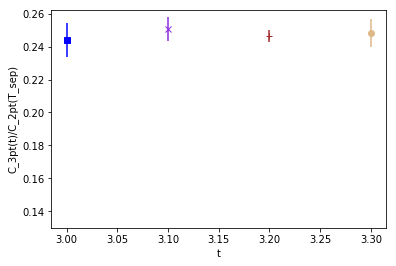

{'x': {'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptTrn': [3.0], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptBC': [3.0], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2pt': [3.0], 'g8.m-0.075_im-0.019938+4+204+T+5+bcpredY3ptdv2pt': [3.0]}, 'y': {'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptTrn': [0.2901662458575619], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptBC': [0.2775910612214493], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2pt': [0.28926572679061713], 'g8.m-0.075_im-0.019938+4+204+T+5+bcpredY3ptdv2pt': [0.28455952140553975]}, 'yerr': {'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptTrn': [0.01322606705796219], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2ptBC': [0.009321906414046064], 'g8.m-0.075_im-0.019938+4+204+T+5+obsvY3ptdv2pt': [0.004491822363859666], 'g8.m-0.075_im-0.019938+4+204+T+5+bcpredY3ptdv2pt': [0.007930947932376845]}}


/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/ruizi/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  al

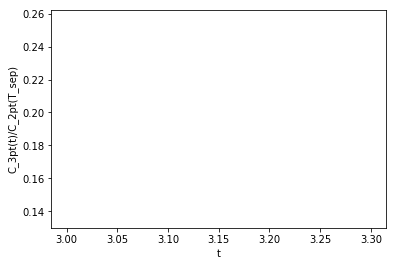

Merge tables
Finished merging tables
self.ave is False


In [5]:
# Wrapper of ML kernals for hadron correlators on lattice
import sys
import os
import datetime
import numpy as np
import yaml as yl
import sklearn.ensemble as sle
import sklearn.tree as slt
import matplotlib.pyplot as plot
import math
from itertools import product

RandTrn = []
RandBC = []
RandUnl = []

noSaveRand = True

# Algorithm depend. params
TOL = 1.0e-4
MIN_SSPLIT = 2
# Minimum #fits
MIN_FIT = 1
# Minimum #training data
MIN_TRAIN = 10
# Minimum #bias correction (bc) data
MIN_BC = 10
# Minimum #unlabeled data
MIN_PREDICT = 10
PRINT = False
SHOW = True

# Class to ML fits 
#   pfile: parameter file
class ML_Regression:
    def __init__(self, pfile, RandTrn=[], RandBC=[], RandUnl=[]):
        params = yl.load(pfile)
        # model list: GradiantBoost, DecisionTree, RandomForest, DeepLearning(using Keras)
        self.mllist = ['GB', 'DT', 'RF', 'DL']
        # pick training data set: Jackknife, Bootstrap, Random, k-fold-CrossValidation
        self.tdlist = ['JK', 'BS', 'RM', 'CV', 'CV1']
        self.form = params['format']
        try:
            self.estimator = params['estimate']
            self.rate = params['rate']
        except:
            self.estimator = None
            self.rate = None
        try:
            self.rmseed = params['rmseed']
        except:
            self.rmseed = 2018
        #np.random.seed(self.rmseed)
        try:
            self.fixRM = params['fixRM']
        except:
            self.fixRM = False
            #self.rmseed = None
        #self.dfile = params['dfile']
        # method to pick training data set: default to pick first self.trn data
        self.nfit = MIN_FIT
        self.print = PRINT
        self.pre_anly = True
        self.fitter_DL = None
        try:
            self.pred = params['pred']
        except:
            self.pred = True
        self.incbc = True
        try:
            self.tdset = params['tdset']
            #print(self.tdset)
            if self.tdset in self.tdlist:
                try:
                    self.nfit = params['nfit']
                except:
                    self.nfit = MIN_FIT
                if self.tdset == 'JK':
                    # Jackknife index
                    try:
                        self.itdpar = params['tdpar']
                    except:
                        self.itdpar = 0
                    self.tdpar = self.itdpar-1
                    self.jk = False
                if self.tdset == 'BS':
                    self.nfit += 1
                    self.bs = False
                    try:
                        self.fixbs = params['fixRM']
                    except:
                        self.fixbs = False
                    if self.fixbs: 
                        self.Rtrn = RandTrn
                        self.Rbc = RandBC
                        self.Runl = RandUnl
                # k-fold Cross-validation: 5 <= k <= 10
                if 'CV' in self.tdset:
                    if self.nfit > 10:
                        self.nfit = 10
                    #if self.nfit < 5:
                    #    self.nfit = 5
                    self.nfit += 1
                    try:
                        self.incbc = params['includeBC']
                    except:
                        self.incbc = False
                    self.cv = False
                    try:
                        self.fixcv = params['fixRM']
                    except:
                        self.fixcv = False
                    if self.fixcv:
                        self.Rm = RandTrn
            elif not isinstance(self.tdset, int):
                print('Warning: Unknown training data subset identifier! Set to 0\n')
                self.tdset = 0
        except:
            self.tdset = 0
        print(self.tdset)
        try:
            self.odir = params['odir']
            self.osave = True
        except:
            self.osave = False
            self.ofile = None
        self.pdir = params['pdir']
        self.mlml = params['mlml']
        pdfile = open(self.pdir+'/'+self.mlml,'r')
        self.pf = yl.load(pdfile)
        pdfile.close()
        try:
            self.anal = params['analysis']
        except:
            self.anal = False
        self.effmass = False
        self.ratio = False
        self.save_tmpfits = False
        self.panal = False
        if self.anal: 
            if self.form == 'pdf':
                self.panal = True
                self.post_anal = ML_Analyze_PDF(params)
                self.save_tmpfits = True
            try:
                self.effmass = params['effmass']
            except:
                self.effmass = False
            try:
                self.ratio = params['ratio']
            except:
                self.ratio = False
        # list of Y momentum
        self.prY = params['momentum_Y']
        # list of Y z's
        self.zrY = params['z_Y']
        try:
            self.prX = params['momentum_X']
            if len(list(self.prX)) == 0:
                self.prX = None
        except:
            self.prX = None
        try:
            self.zrX = params['z_X']
            if len(list(self.zrX)) == 0:
                self.zrX = None
        except:
            self.zrX = None
        try:
            self.orY = params['operator_Y']
            if len(list(self.orY))==0:
                self.orY = [None]
        except:
            self.orY = [None]
        try:
            self.orX = params['operator_X']
            if len(list(self.orX))==0:
                self.orX = [None]
        except:
            self.orX = [None]
        try:
            self.srY = params['T_Y']
        except:
            self.srY = [None]
        try:
            self.srX = params['T_X']
        except:
            self.srX = [None]
        # list of Y time slices
        try:
            self.tr = params['ts_Y']
            if self.tr is None:
                self.tr = [None]
            elif len(list(self.tr)) == 0:
                self.tr = [None]
        except: 
            self.tr = [None]
        # list of X & Y time differences
        self.dtr = params['dts_X']
        # number of sources per configuration
        try:
            self.tfold = params['nsrc']
        except:
            self.tfold = 0
        self.ntrn = params['ntrn']
        if isinstance(self.ntrn, (int, str)):
            assert(int(self.ntrn) >= MIN_TRAIN)
            self.ntrn = [int(self.ntrn)]
        else:
            assert(len(self.ntrn) == len(self.prX))
        self.nbc = params['nbc']
        if isinstance(self.nbc, (int, str)):
            assert(int(self.nbc) >= MIN_BC)
            self.nbc = [int(self.nbc)]
        else:
            assert(len(self.nbc) == len(self.prX))
        # read in data stored in data pool 'database'
        # params[]: 
        #     format (data format, 'raw','pdf'); 
        #     binsize (data bin); 
        #     ddir (data files directory)
        #     dfile.x (X data filename); 
        #     dfile.y (Y data filename);
        print("Reading data...\n")
        self.database = Data_IO(params, self.tdset)
        print("Done reading data\n")
        self.data = None
        self.ndata = 0
        self.model = None
        self.fitnow = None
        self.isset = False
        self.errscale = None
        self.date = self.database.date #datetime.datetime.today().strftime('%m%d%Y')
        # Data IO, moved to the io kernel 
        return
    
    # clear data, free memory
    def finalize(self): 
        if self.panal: 
            self.post_anal.finalize()
        self.cleanup_data()
        self.del_data()
        self.database.finalize()
        if (self.tdset == 'BS') and (self.fixbs is True):
            del self.Rtrn
            del self.Rbc
            del self.Runl
            self.Rtrn = None
            self.Rbc = None
            self.Runl = None
        if 'CV' in self.tdset:
            del self.Rm
            self.Rm = None
        return
        
    # Initialize fits
    # Select correlator characters, p (momentum), z (Wilson link lenght), t (sink time slice), etc., 
    #        data sets, and assign the fit model
    def inifit(self, fdparX, fdparY, indx):
        print("Initfit...\n")
        self.ftag = None
        self.dtag = None
        self.p = None
        self.c = None
        self.y = None
        if self.del_data: 
            self.data = {}
            self.add2pt = False
            if self.ratio:
                #print("Y tags are {:}".format(fdparY))
                deltagY, self.ftag, self.spectag, self.data['Y'], self.data['S'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = len(self.spectag)
                print("spectag is {:}\n".format(self.spectag))
                self.add2pt = (self.n2pt > 0)
            else:
                deltagY, self.ftag, self.data['Y'], self.dmeanY, self.dstdY = self.database.select_data(fdparY, 'Y', self.ratio)
                self.n2pt = 0
            if self.data['Y'].shape[0]==0:
                self.ny=0
                self.nx=0
                self.fitnow = self.nfit
                return
            self.dtX, self.dtag, self.data['X'], self.dmeanX, self.dstdX = self.database.select_data(fdparX, 'X')       
        #print("self.data['X'] is {:}".format(self.data['X']))
        self.ndata = self.data['X'].shape[0]
        if self.ndata > self.data['Y'].shape[0]:
            self.ndata = self.data['Y'].shape[0]
        if ('CV' in self.tdset) or ('JK' in self.tdset):
            self.mlscr = []
            self.mlscr0 = []
            self.cvbs = []
            self.pdtrn = []
            self.pdtst = []
            if 'CV' in self.tdset:
                self.cv = False
            #if self.ndata / (self.nfit-1) < 50:
             #   self.nfit = int(self.ndata/50.0) + 1
        self.nx = self.data['X'].shape[1]
        self.ny = len(self.ftag) #self.data['Y'].shape[1]
        self.Ny = self.n2pt + self.ny
        print("Shape of X / Y : {:} / {:}".format(self.nx, self.ny))
        try:
            self.trn = self.ntrn[indx]
        except:
            self.trn = self.ntrn[0]
        try:
            self.bc = self.nbc[indx]
        except:
            self.bc = self.nbc[0]
        self.lbl = self.trn + self.bc
        self.unlbl = self.ndata - self.lbl
        if self.tdset == 'JK':
            self.nfit = int(self.trn) + 1
            self.tdpar = self.itdpar-1
            self.jk = False
        if self.tdset == 'BS':
            self.bs = False
        # verify number of train & test data
        if ('CV' in self.tdset) and (int(self.ndata / self.unlbl) != self.nfit-1):
            if self.tdset == 'CV':
                self.unlbl = int(self.ndata/(self.nfit-1))
                self.lbl = self.ndata - self.unlbl
            else:
                self.lbl = int(self.ndata/(self.nfit-1))
                self.unlbl = self.ndata - self.lbl
            if self.incbc:
                self.trn = int(self.trn*self.lbl/(self.trn+self.bc))
                self.bc = self.lbl-self.trn
            else:
                self.trn = self.lbl
                self.bc = 0
        self.bin = int((self.ndata+self.lbl-1)/self.lbl)
        #self.bin = 1
        self.data_reorder()
        if self.tdset == 'JK' or self.tdset == 'RM':
            self.N = self.data['X'][self.lbl:]
            self.P = self.data['Y'][self.lbl:]
        if self.model != None:
            del self.model
        self.model = self.make_model(indx)
        self.isset = False
        self.errscale = None
        self.fitnow = 0
        if self.osave:
            self.database.dfile_mkheader(indx)
            self.ml_mkheader()
        #print("self.data['X'] is {:}".format(self.data['X']))
        if self.panal:
            print("Adding table")
            self.post_anal.add_table(self.database.NT, self.ndata, self.trn, self.bc, pztY=self.ftag, pztX=self.dtag)
            print("Finishing adding table")
        print("Done initfit\n")
            
    def isfit(self):
        return self.fitnow < self.nfit
        
    # Reorder data (scatter)
    def data_reorder(self):
        #print("self.data['X'] is {:}".format(self.data['X']))
        tmpx = self.data['X']
        tmpy = self.data['Y']
        self.data['X'] = []
        self.data['Y'] = []
        if self.add2pt:
            tmps = self.data['S']
            self.data['S'] = []
        for i in range(self.bin):
            self.data['X'].extend(tmpx[i:self.ndata:self.bin].tolist())
            self.data['Y'].extend(tmpy[i:self.ndata:self.bin].tolist())
            if self.add2pt:
                self.data['S'].extend(tmps[i:self.ndata:self.bin].tolist())
        del tmpx
        del tmpy
        if self.add2pt:
            del tmps
        #print("self.data['X'] is {:}".format(self.data['X']))

    # build up the fit model
    def make_model(self, indx=None):
        assert(self.mlml in self.mllist) 
        if self.mlml == 'GB':
            return self.make_model_GB(indx)
        elif self.mlml == 'DT':
            return self.make_model_DT()
        elif self.mlml == 'RF':
            return self.make_model_RF()
        else:
            return self.make_model_DL()
        
    def ml_mkheader(self):
        if self.osave is False: 
            return
        pf = open(self.database.ofile, 'a')
        if self.mlml == 'GB': 
            pf.write("\n GB parameters: (random seed {:}) \n nestimator:  {:} \n \
            lnrate:  {:} \n lossfunc:  {:} \n subsample:  {:} \n \
            max_depth:  {:} \n lntol:  {:} \n verbose:  {:} \n\n".format(self.rmseed, self.GB_nestimator, 
                                                                         self.GB_lnrate, self.GB_lossfunc, self.GB_ssample, 
                                                                         self.GB_mdth, self.GB_tol, self.GB_verbose))
        pf.close()
        return
    
    # Gradient Boosting
    def make_model_GB(self, indx=None):
        if indx is None:
            self.GB_nestimator = self.pf['nestimator']
            self.GB_lnrate = self.pf['lnrate']
        else:
            try:
                self.GB_nestimator = self.estimator[indx]
                self.GB_lnrate = self.rate[indx]
            except:
                self.GB_nestimator = self.pf['nestimator']
                self.GB_lnrate = self.pf['lnrate']
        try:
            self.GB_lossfunc = self.pf['lossfunc']
        except:
            self.GB_lossfunc = 'ls'
        try:
            self.GB_ssample = self.pf['subsample'] #= float(self.trn) / float(self.ndata)
            GB_schn = int(10/self.GB_ssample)
        except:
            self.GB_ssample = 1.0
            GB_schn = 1
        try:
            self.GB_mdth = self.pf['max_depth']
        except:
            self.GB_mdth = 3
        try:
            self.GB_tol = self.pf['lntol']
        except:
            self.GB_tol = TOL
        try:
            self.GB_verbose = self.pf['verbose']
        except:
            self.GB_verbose = False
        print("GB parameter rate is {:}".format(self.GB_lnrate))
        model = [ sle.GradientBoostingRegressor(loss=self.GB_lossfunc, learning_rate=self.GB_lnrate, 
                                             n_estimators=self.GB_nestimator, max_depth=self.GB_mdth, 
                                             subsample=self.GB_ssample,
                                            tol=self.GB_tol) #for j in range(GB_schn) ]
                 for i in range(self.ny) ]
        #self.ml_mkheader()
        return model
        
    # Decistion Tree
    def make_model_DT(self):
        try:
            self.DT_ctr = self.pf['criterion']
        except:
            self.DT_ctr = 'mse'
        self.DT_mdth = None
        self.DT_mspt = None
        try:
            self.DT_mspt = self.pf['min_samples_split']
        except:
            try:
                self.DT_mdth = self.pf['max_depth']
                self.DT_mspt = None
            except:
                self.DT_mspt = MIN_SSPLIT
                self.DT_mdth = None
        try:
            self.DT_verbose = self.pf['verbose']
        except:
            self.DT_verbose = False
        model = [ slt.DecisionTreeRegressor(criterion=self.DT_ctr, max_depth=self.DT_mdth,
                                        min_samples_split=self.DT_mspt)
                 for i in range(self.ny) ]
        return model
            
    # Random Foreast
    def make_model_RF(self):
        # FIXME
        return None
    
    def make_model_DL(self):
        self.fitter_DL = DL_Regression(self.pf, self.ny)
        return self.fitter_DL.model
    
    def make_oheader(self, parY, parX, indx):
        self.database.dfile_mkheader()
        self.ml_mkheader()
        return
    
    # set up data: Train [X,Y]; BC [B,C]; Unlabeled [N,P]
    def setup_data(self):
        self.fitnow += 1
        if self.save_tmpfits: 
            self.post_anal.append_table(self.database.odir)
        if self.isset:
            return True
        if isinstance(self.tdset, int):
            try:
                self.X = self.data['X'][self.tdset:self.tdset+self.trn]
                self.Y = self.data['Y'][self.tdset:self.tdset+self.trn]
                self.B = self.data['X'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                self.C = self.data['Y'][self.tdset+self.trn:self.tdset+self.trn+self.bc]
                if self.add2pt:
                    self.S = self.data['S'][self.tdset:]
            except:
                print('Labeled data subset out of index range!\n')
                sys.exit()
            self.N = list(self.data['X'][self.tdset+self.lbl:])
            self.P = list(self.data['Y'][self.tdset+self.lbl:])
            if self.tdset > 0:
                self.N.extend(self.data['X'][:self.tdset])
                self.P.extend(self.data['Y'][:self.tdset])
                if self.add2pt:
                    self.S.extend(self.data['S'][:self.tdset])
            self.tdset+=1
        else:
            if self.tdset == 'JK':
                if self.jk: 
                    self.X = []
                    self.Y = []
                    if self.add2pt:
                        self.S = []
                    self.tdpar+=1
                    if self.tdpar < 0 or self.tdpar > self.trn:
                        return self.isset
                    if self.tdpar > 0:
                        self.X.extend(self.data['X'][:self.tdpar])
                        self.Y.extend(self.data['Y'][:self.tdpar])
                        if self.add2pt:
                            self.S.extend(self.data['S'][:self.tdpar])
                    if self.tdpar < self.trn:
                        self.X.extend(self.data['X'][self.tdpar+1:self.trn+1])
                        self.Y.extend(self.data['Y'][self.tdpar+1:self.trn+1])
                        if self.add2pt:
                            self.S.extend(self.data['S'][self.tdpar+1:self.trn+1])
                    self.B = []
                    self.C = []
                    self.B.extend(self.data['X'][self.trn+1:self.lbl])
                    self.B.append(self.data['X'][self.tdpar])
                    self.C.extend(self.data['Y'][self.trn+1:self.lbl])
                    self.C.append(self.data['Y'][self.tdpar])
                    if self.add2pt:
                        self.S.extend(self.data['S'][self.trn+1:self.lbl])
                        self.S.append(self.data['S'][self.tdpar])
                        self.S.extend(self.data['S'][self.lbl:])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    #self.N = self.data['X'][self.lbl:]
                    #self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.jk = True
            elif self.tdset == 'BS':
                if self.bs:
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if self.fixbs:
                        if len(self.Rtrn) < self.nfit-1:
                            self.Rtrn.append(np.random.randint(0, self.lbl, self.trn))
                            #RandTrn = np.array(self.Rtrn)
                            #print("RandTrn is {:}".format(RandTrn))
                        if len(self.Rbc) < self.nfit-1:
                            self.Rbc.append(np.random.randint(0, self.lbl, self.bc))
                            #RandBC = np.array(self.Rbc)
                            #print("RandBC is {:}".format(RandBC))
                        if len(self.Runl) < self.nfit-1: 
                            self.Runl.append(np.random.randint(self.lbl,self.ndata, self.unlbl))
                            #RandUnl = np.array(self.Runl)
                            #print("RandUnl is {:}".format(RandUnl))
                    for i in range(self.trn):
                        if self.fixbs:
                            r = self.Rtrn[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        if self.fixbs:
                            r = self.Rbc[self.fitnow-2][i]
                        else:
                            r = np.random.randint(0,self.lbl)
                        #r = np.random.randint(0,self.lbl)
                        #print("Rand is {:}".format(r))
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        if self.fixbs:
                            r = self.Runl[self.fitnow-2][i]
                        else:
                            r = np.random.randint(self.lbl,self.ndata)
                        #r = np.random.randint(self.lbl,self.ndata)
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.bs = True
            elif self.tdset == 'CV':
                if (self.fitnow-1)*self.unlbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.unlbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[(stcv+self.unlbl+i)%self.ndata]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.unlbl+self.trn+i)%self.ndata]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            elif self.tdset == 'CV1':
                if (self.fitnow-1)*self.lbl > self.ndata:
                    self.isset = False
                    self.fitnow = self.nfit
                    if self.save_tmpfits:
                        self.post_anal.pop_table()
                    return False
                if self.cv:
                    stcv = (self.fitnow-2)*(self.lbl) 
                    self.X = []
                    self.Y = []
                    self.B = []
                    self.C = []
                    self.N = []
                    self.P = []
                    if self.add2pt:
                        self.S = []
                    if len(self.Rm) < self.ndata:
                        self.Rm = np.random.permutation(self.ndata)
                    for i in range(self.trn):
                        r = self.Rm[stcv+i]
                        self.X.append(self.data['X'][r])
                        self.Y.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.bc):
                        r = self.Rm[(stcv+self.trn+i)]
                        self.B.append(self.data['X'][r])
                        self.C.append(self.data['Y'][r])
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                    for i in range(self.unlbl):
                        r = self.Rm[(stcv+self.lbl+i)%self.ndata]
                        self.N.append(self.data['X'][r])
                        self.P.append(self.data['Y'][r]) 
                        if self.add2pt:
                            self.S.append(self.data['S'][r])
                else:
                    self.X = self.data['X'][:self.trn]
                    self.Y = self.data['Y'][:self.trn]
                    self.B = self.data['X'][self.trn:self.lbl]
                    self.C = self.data['Y'][self.trn:self.lbl]
                    self.N = self.data['X'][self.lbl:]
                    self.P = self.data['Y'][self.lbl:]
                    if self.add2pt:
                        self.S = self.data['S'].copy()
                    self.cv = True
            else:
                pm = np.random.permutation(self.lbl)
                self.X = [self.data['X'][pm[i]] for i in range(self.trn)]
                self.B = [self.data['X'][pm[i]] for i in range(self.trn,self.lbl)]
                self.Y = [self.data['Y'][pm[i]] for i in range(self.trn)]
                self.C = [self.data['Y'][pm[i]] for i in range(self.trn,self.lbl)]
                if self.add2pt:
                    self.S = [ self.data['S'][i] for i in pm ]
        self.isset = True
        return self.isset
        
    def del_data(self):
        if self.data == None:
            return True
        if 'X' in self.data:
            del self.data['X']
        if 'Y' in self.data:
            del self.data['Y']
        if 'S' in self.data:
            del self.data['S']
        self.data = None
        try:
            del self.mlscr
            del self.mlscr0
            del self.cvbs
            del self.pdtrn
            del self.pdtst
        except:
            pass
        del self.dmeanX
        del self.dmeanY
        del self.dstdY
        del self.dstdX
        self.dmeanX = None
        self.dmeanY = None
        self.dstdY = None
        self.dstdX = None
        return True
    
    # clean up data
    def cleanup_data(self):
        if self.isset is False:
            return 
        if self.tdset in self.tdlist:
            del self.X
            del self.Y
            del self.B
            del self.C
        if self.tdset == 'BS' or isinstance(self.tdset, int):
            del self.N
            del self.P
        if self.y is not None:
            del self.y
            del self.c
            del self.p
            self.y = None
            self.c = None
            self.p = None
        if self.add2pt:
            del self.S
        self.isset = False
        return
    
    # Plot data statistics: histograms, density, correlations
    def data_statistic(self, data, tag = None):
        ddf = Dataframe(data, tag=tag)
        print(ddf.data.describe())
        binmin, atc = ddf.autocorr(0.1)
        print('Data blocksize {:d} with autocorrelation {:f} \n'.format(binmin, atc))
        print("self.nx is {:}".format(self.nx))
        ddf.hist((self.nx,None),self.database.pltfile)
        ddf.density((self.nx,None),self.database.pltfile)
        ddf.covplot(prange=((0, self.nx), (self.nx, None)), out=self.database.pltfile)
        return
        

    # Prediction bias Correction
    def bias_crrt(self):
        if self.c is not None:
            del self.c
            self.c = None
        if self.p is not None:
            del self.p
            self.p = None
        if self.y is not None:
            del self.y
            self.y = None
        if self.incbc and (self.bc > 0):
            self.c = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.B).tolist()) 
                            for i in range(self.ny)])
        self.p = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist()) 
                            for i in range(self.ny)])
        self.y = np.array([self.model[i].predict(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist()) 
                            for i in range(self.ny)])
        if (self.tdset=='JK') and (self.fitnow==1) and (self.bc > 0):
            if self.osave:
                pf = open(self.database.ofile, 'a+')
                pf.write("Bias correction data statistic: {:} +/- {:}\n".format(np.array(self.C).mean(axis=0)[0]*self.dstdY[0], self.dstdY[0]*np.array(self.C).std(axis=0, ddof=1)[0]/math.sqrt(len(self.C))))
                pf.close()
        # Cross-validation: Add prediction scores
        if ('CV' in self.tdset and self.cv) or ('JK' in self.tdset and self.jk):
            self.mlscr.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.N).tolist(), np.array(self.P).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.mlscr0.append(np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), np.array(self.Y).T[i].tolist()) 
                            for i in range(self.ny)]))
            self.cvbs.append(np.array(self.Y).mean(axis=0) - self.p.mean(axis=1))
            self.pdtrn.append(self.y.mean(axis=1))
            self.pdtst.append(self.p.mean(axis=1))
        if self.incbc and (self.bc > 0):
            C_arr = np.ndarray(shape=(self.bc,self.ny),buffer=np.array(self.C)).T
        # Prediction matrix of size ny*ndata
        predata = np.array([self.model[i].predict(
            self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist())  
                            for i in range(self.ny)])
        print(predata.shape)
        omat = np.ndarray(shape=(2*self.ny, self.ndata), 
                          buffer=np.array([
                              predata.tolist(), 
                              np.array(self.data['Y']).T.tolist()]))
                     #     dtype=float)
        # generate covariance matrix, predictions first
        ocov = np.cov(omat)
        print('shape of OCOV: {:}'.format(ocov.shape))
        if self.incbc and (self.bc > 0):
            # Bias correction equation
            obc = np.array([self.p[i].mean() + C_arr[i].mean() - self.c[i].mean() for i in range(self.ny)])
            for o in obc:
                print(o)
        else:
            obc = np.array([self.p[i].mean() for i in range(self.ny)])
        s2 = np.array([ocov[i,i]/ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        r = np.array([(ocov[i,i+self.ny]**2/(ocov[i,i]*ocov[i+self.ny,i+self.ny])) for i in range(self.ny)])
        osigma = np.array([ocov[i+self.ny,i+self.ny] for i in range(self.ny)])
        srs2r = np.array([math.sqrt(s2[i]*r[i]) for i in range(self.ny)])
        if self.incbc and (self.bc > 0):
            bcvar = osigma/self.lbl*(s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)
        else:
            bcvar = osigma*s2/self.unlbl
        if self.errscale is None:
            if self.incbc and (self.bc > 0):
                self.errscale = (s2*self.lbl/self.unlbl + (1.+s2-2.*srs2r)*self.lbl/self.bc)/self.lbl
            else:
                self.errscale = s2*self.lbl/self.unlbl
            self.errscale = np.array([math.sqrt(self.errscale[i]) for i in range(self.ny)])
            print("Correlation coefficient between Pred. & Obsd. {:}".format([math.sqrt(r[i]) for i in range(self.ny)]))
            print("error scale: {:}".format(self.errscale))
            if False: #if self.anal:
                self.post_anal.extend_table('errscl', self.errscale)
            if self.osave: 
                pf = open(self.database.ofile, 'a+')
                pf.write("Correlation coefficient between Pred. & Obsd. {:}\n".format([math.sqrt(r[i]) for i in range(self.ny)]))
                pf.write("error scale: {:}\n".format(self.errscale))
                pf.close()
        return (obc, np.array([math.sqrt(bcvar[i]) for i in range(self.ny)]))
    
    def imp_prdt(self, bc):
        return bc
    
    def add_anal(self):
        if self.save_tmpfits:
            #self.post_anal.extend_table({"ycov": ocov})
          #  self.post_anal.extend_table({"ymean": obc})
           # self.post_anal.extend_table({"y": omat})
            if False: #for i in range(self.ny):
                print("{:}: {:}".format(self.ftag[i], np.array(self.Y).T[i]))
            if self.incbc and (self.bc > 0):
                self.post_anal.add_data(tag=self.ftag, dscale=self.dstdY, 
                                    dtrn=np.array(self.Y).T, dbc=np.array(self.C).T, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            else:
                self.post_anal.add_data(tag=self.ftag, dscale=self.dstdY, 
                                    dtrn=np.array(self.Y).T, dbc=None, 
                                    dunlbl=np.array(self.P).T, pred=False, overwrite=True)
            if self.pred:
                if self.incbc and (self.bc > 0):
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dstdY, 
                                    dtrn=self.y, dbc=self.c, 
                                    dunlbl=self.p, pred=None, overwrite=True)
                else:
                    self.post_anal.add_data(tag=self.ftag, dscale=self.dstdY, 
                                    dtrn=self.y, dbc=None, 
                                    dunlbl=self.p, pred=True, overwrite=True)
            if self.effmass:
                self.post_anal.effmass(tag=self.ftag, pred=False)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=1)
                #self.post_anal.effmass(tag=self.ftag, pred=False, subset=2)
                self.post_anal.effmass(tag=self.ftag, subset=1, pred=False)
                self.post_anal.effmass(tag=self.ftag, subset=2, pred=False)
                if self.pred:
                    #self.post_anal.effmass(tag=self.ftag, pred=True)
                    if self.incbc:
                        self.post_anal.effmass(tag=self.ftag, pred=None)
            if self.ratio:
                if self.add2pt:
                    self.post_anal.add_data(tag=self.spectag, #dscale=self.dmeanY, 
                                        #dtrn=np.array(self.Y).T[self.ny:,:], 
                                        #dbc=np.array(self.C).T[self.ny:,:], dunlbl=np.array(self.P).T[self.ny:,:], 
                                        data=np.array(self.S).T, 
                                        pred=False, NT=self.database.NT, is2pt=True)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=False)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=1, pred=False)
                self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=2, pred=False)
                #self.post_anal.ratio3ptn2pt(tag=self.ftag, subset=0, pred=False)
                if self.pred:
                    if self.incbc:
                        self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=None)
                    #self.post_anal.ratio3ptn2pt(tag=self.ftag, pred=True)
        return
        
    # Post-fits analysis
    def analyze(self, bc, pd, dmeanY, stdY):
        if self.ny==0:
            return
        if self.osave:
            pf = open(self.database.ofile, 'a+')
        if self.pred:
            scr = np.array([self.model[i].score(
                self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.data['X']).tolist(), 
                np.array(self.data['Y']).T.tolist()[i]) for i in range(self.ny)])
            # Cross-validation: Prediction score statistics
            if ('CV' in self.tdset) or ('JK' in self.tdset):
                scrmean = np.array(self.mlscr).mean(axis=0)
                scrmean0 = np.array(self.mlscr0).mean(axis=0)
                scrstd = np.array(self.mlscr).std(axis=0,ddof=1)
                scrstd0 = np.array(self.mlscr0).std(axis=0,ddof=1)
                bs = np.array(self.cvbs).mean(axis=0) * self.dstdY
                bss = np.array(self.cvbs).std(axis=0,ddof=1) * self.dstdY#/abs(bs)
                pdtrnmean = np.array(self.pdtrn).mean(axis=0) * self.dstdY
                pdtrnstd = np.array(self.pdtrn).std(axis=0, ddof=1) * self.dstdY
                pdtstmean = np.array(self.pdtst).mean(axis=0) * self.dstdY
                pdtststd = np.array(self.pdtst).std(axis=0, ddof=1) * self.dstdY
                if 'JK' in self.tdset:
                    bss *= float(self.unlbl-1)/math.sqrt(float(self.unlbl))
                    scrstd *= float(self.unlbl-1)/math.sqrt(float(self.unlbl))
                    scrstd0 *= float(self.unlbl-1)/math.sqrt(float(self.unlbl))
                    pdtrnstd *= float(self.unlbl-1)/math.sqrt(float(self.unlbl))
                    pdtststd *= float(self.unlbl-1)/math.sqrt(float(self.unlbl))
            if self.tdset == 'BS' or self.tdset == 'JK':
                oimp = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[::2]).T
                oimpstd = np.array(np.array(pd[1:]).reshape(2*len(pd[1:]),self.ny)[1::2]).T
                print("OIMP is {:}\n".format(oimp))
                omean = np.array([oimp[i].mean() for i in range(self.ny)])
                omeanstd = np.array([oimpstd[i].mean() for i in range(self.ny)])
                #print(omean)
                ostd = np.array([oimp[i].std(ddof=1) for i in range(self.ny)])
                oymean1 = np.array(dmeanY[1:]).mean(axis=0)
                oystd1 = np.array(stdY[1:]).mean(axis=0) #np.array(dmeanY[1:]).std(axis=0, ddof=1)
                if self.tdset == 'BS':
                    print(pd[0][0])
                    obc = 2.*pd[0][0]-omean
                    oymean1 = 2.*dmeanY[0] - oymean1
                else:
                    obc = omean #self.lbl*pd[0][0]-(self.lbl-1)*omean
                    print("OBC is {:}\n".format(obc))
                    ostd *= (len(oimp[0])-1)/math.sqrt(float(len(oimp[0])))
                    #print("length of dmeanY[0] is {:}\n".format(len(dmeanY)))
                    #oystd1 *= (len(dmeanY)-2)/math.sqrt(float(len(dmeanY)-1))
                ostd = np.array([math.sqrt(ostd[i]**2+omeanstd[i]**2) for i in range(self.ny)])
            else:
                #oimp = np.array(pd[:][0]).T
                oimp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[::2]).T
                obc = np.array([oimp[i].mean() for i in range(self.ny)])
                simp = np.array(np.array(pd).reshape(2*len(pd),self.ny)[1::2]).T
                ostd = np.array([[oimp[i].std(ddof=1), simp[i].mean()] for i in range(self.ny)])
                oymean1 = np.array(dmeanY).mean(axis=0)
                oystd1 = np.array(dmeanY).std(axis=0, ddof=1)
            self.res = (scr, obc, ostd)
            oy = np.array(self.P).T
            oymean = np.array([oy[i].mean() for i in range(self.ny)]) * self.dstdY
            #oystd = np.array([oy[i].std(ddof=1) for i in range(self.ny)]) * self.dmeanY/math.sqrt(self.unlbl)
            print("self.dstdY is {:}".format(self.dstdY))
            oystd = np.array(stdY).mean(axis=0) #/ math.sqrt(float(self.unlbl))
            if False:
                print("Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
               \t {:} (re)sampling {:d} fits \n \
               \t score = {:}; Predicted Mean / Observed: \
               \t {:} +- {:} / {:} +- {:} \n".format(self.nx, self.ndata, self.trn,self.bc, self.unlbl, 
                                                             self.tdset, self.nfit, 
                                                             scr, obc*self.dstdY, ostd*abs(self.dstdY),  
                                                             oymean, oystd))
            IR = ['R', 'I']
            if ('CV' in self.tdset) or ('JK' in self.tdset):
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t scrall = {:}; \n \
                    \t score = {:}; \n scrstd = {:}; \n\
                    \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr, scrmean0, scrstd0))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dstdY[i], ostd[i]*abs(self.dstdY[i]), 
                                                                              oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
            else:
                print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                    \t {:} (re)sampling {:d} fits \n \
                    \t score = {:}; \n \
                    \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                    self.tdset, self.nfit, 
                                                    scr))
                for i in range(self.ny): 
                    print("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} ".format(int(i/2), IR[i%2], 
                                                                               obc[i]*self.dstdY[i], ostd[i]*abs(self.dstdY[i]), 
                                                                              oymean1[i], oystd1[i]))
            print('\n\n')
            if ('CV' in self.tdset) or ('JK' in self.tdset):
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t scrall = {:}; \n \
                \t score = {:}; \n scrstd = {:}; \n\
                \t Y's \t Predicted Mean / Observed \t Bias-correction \t Score: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr, scrmean0, scrstd0))#scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \t {:8e} +- {:} \t {:8e} +- {:}\n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dstdY[i], ostd[i]*abs(self.dstdY[i]), 
                                                                          oymean[i], oystd[i], bs[i], bss[i], scrmean[i], scrstd[i]))
                pf.write("\t Y's \t Predicted Mean (training data) \t Predicted Mean (wo. bias-correction): \n")
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} \t {:8e} +- {:}\n".format(int(i/2), IR[i%2], pdtrnmean[i], pdtrnstd[i], pdtstmean[i], pdtststd[i]))
            else:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n \
                \t score = {:}; \n\
                \t Y's \t Predicted Mean / Observed: \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit, 
                                                scr))
                IR = ['R', 'I']
                for i in range(self.ny): 
                    pf.write("\t Y{:d}.{:s} \t {:8e} +- {:} / {:8e} +- {:} \n".format(int(i/2), IR[i%2], 
                                                                           obc[i]*self.dstdY[i], ostd[i]*abs(self.dstdY[i]), 
                                                                          oymean1[i], oystd1[i]))
        else:
            print("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
            if self.osave:
                pf.write("\n Analysis result: {:d} * {:d} data {:d}/{:d}/{:d} tr/bc/unlbl; \n \
                \t {:} (re)sampling {:d} fits \n".format(self.nx, self.ndata, self.trn, self.bc, self.unlbl, 
                                                self.tdset, self.nfit))
        if self.osave:
            if self.anal:
                if self.effmass:
                    self.post_anal.print_effmassv2(self.tdset, pf, ppf=self.database.pltfile)
                if self.ratio:
                    self.post_anal.print_ratio3ptn2ptv2(self.tdset, pf, ppf=self.database.pltfile)
            pf.write("\n\n\n")
            pf.close()
        if self.panal:
            print("Merge tables")
            self.post_anal.merge_table()
            print("Finished merging tables")
            # no need to save current analysis results
            self.post_anal.drop_table()
    
    def print_fit(self, pd):
        for r in pd:
            print(r)
    
    # Do fits
    def fit(self):
        res = []
        bc = []
        pd = []
        dmeanY = []
        stdY = []
        n=0
        while self.isfit(): #for i in range(self.nfit):
            if self.setup_data():
                # Print data statistics
                if False:#n == 1:
                    print("Training data statistic\n")
                    data = {}
                    data['X'] = np.array(self.X).reshape(self.trn, self.nx)
                    data['Y'] = np.array(self.Y).reshape(self.trn, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Bias correction data statistic\n")
                    data['X'] = np.array(self.B).reshape(self.bc, self.nx)
                    data['Y'] = np.array(self.C).reshape(self.bc, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                    print("Unlabeled data statistic\n")
                    data['X'] = np.array(self.N).reshape(self.unlbl, self.nx)
                    data['Y'] = np.array(self.P).reshape(self.unlbl, self.ny)
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                # yield to DL fitter
                if self.fitter_DL is not None:
                    res.append(self.fitter_DL.fit(self.X, self.Y, self.B, self.C))
                elif self.pred:
                    print("ny = {:} \n\n self.Y shape {:} X shape {:}\n\n".format(self.ny, np.array(self.Y).shape, np.array(self.X).shape))
                    res.append(np.array([self.model[i].fit(
                        self.database.select_T(self.dtag, self.dtX, self.ftag[i], self.X).tolist(), 
                        np.array(self.Y).T.tolist()[i]) for i in range(self.ny)]))
                    print("finished fitting\n\n")
                #print(res[-1])
                    bc.append(self.bias_crrt())
                    print(bc[-1])
                    pd.append(self.imp_prdt(bc[-1]))
                    print(pd[-1])
                    mn = np.array(self.P).mean(axis=0)
                    print("mean of self.P is {:} \n self.dmeanY is {:}".format(mn, self.dmeanY))
                    dmeanY.append(np.array(mn*self.dstdY).tolist())
                    stdY.append(np.array(np.array(self.P).std(axis=0, ddof=1)/math.sqrt(len(self.P))*self.dstdY).tolist())
                    print("std of self.P is {:}\n".format(stdY[-1]))
                if self.panal:
                    self.add_anal()
                if False:#n == 1:
                    print("Predicted data statistics\n")
                    data = {'X': np.array(self.N).reshape(self.unlbl,self.nx), 'Y': np.array(self.p).T}
                    self.data_statistic(data, {'X': self.dtag, 'Y': self.ftag})
                self.cleanup_data()
                if self.print:
                    self.print_fit(pd)
                n+=1
        if self.anal: 
            self.analyze(bc, pd, dmeanY, stdY)
        return

    def show_fit(self):
        return
            
    def runraw(self):
        par = [1, 0]
        print("inifit\n")
        self.inifit(par, par, 0)  
        print("Doing fit\n")
        self.fit()
        #self.analyze()
        return
        
    # runs over loops of input parameters
    def run(self):
        tlist = (tuple, list)
        print("Running ML...\n")
        for pi in range(len(self.prY)):
            try:
                oy = self.orY[pi]
            except:
                oy = self.orY[0]
            try:
                ox = self.orX[pi]
            except:
                ox = self.orX[0]
            if isinstance(self.prY[pi], tlist):
                py = self.prY[pi]
            else:
                py = [self.prY[pi]]
            if self.prX is None:
                px = None
            else:
                try:
                    px = self.prX[pi]
                except:
                    px = self.prX[0]
            if isinstance(self.zrY[pi], tlist):
                zy = list(self.zrY[pi])
            else:
                zy = [self.zrY[pi]]
            if self.zrX is None:
                zx = None
            else:
                try:
                    zx = self.zrX[pi]
                except:
                    zx = self.zrX[0]
            print("X z's is {:}".format(zx))
            if False:
                if isinstance(self.zrX[pi], tlist):
                    zx = list(self.zrX[pi])
                else:
                    zx = [self.zrX[pi]]
            for tsp in range(len(self.srY)):
                if isinstance(self.srY[tsp], tlist):
                    tsy = list(self.srY[tsp])
                else:
                    tsy = [self.srY[tsp]]
                try:
                    if isinstance(self.srX[tsp], tlist):
                        tsx = list(self.srX[tsp])
                    else:
                        tsx = [self.srX[tsp]]
                except:
                    tsx = self.srX[0]
                for ti in range(len(self.tr)):
                    if isinstance(self.tr[ti], tlist):
                        ty = list(self.tr[ti])
                    else:
                        ty = [self.tr[ti]]
                    if None in ty:
                        ty = None
                    try:
                        if isinstance(self.dtr[ti], tlist):
                            dtx = self.dtr[ti]
                        else:
                            dtx = self.dtr
                    except:
                        dtx = self.dtr
                    if False:
                        tx = []
                        for t,dt in product(ty, dtx):
                            tx.append(t+dt)
                        ttx = np.array(tx)
                        ttx.sort()
                        del tx
                        tx = []
                        tx.append(ttx[0])
                        for i in range(1, ttx.size):
                            if ttx[i] != tx[-1]:
                                tx.append(ttx[i])
                    parX = [ox, px, zx, tsx, ty, dtx]
                    parY = [oy, py, zy, tsy, ty, None]
                    print(py)
                    print(zy)
                    self.inifit(parX, parY, pi)
                    #if True: #self.pre_anly:
                    #    self.data_statistic(self.data)  
                    self.fit()
                    if SHOW:
                        self.show_fit()
                # spectrum only, ignore loop over 'T'
                if zy == [self.database.NA]:
                    break
        return

   

def main(pfile, RandTrn, RandBC, RandUnl, noSaveRand, raw=False):
    ml = ML_Regression(pfile, RandTrn, RandBC, RandUnl)
    if raw:
        ml.runraw()
    else:
        ml.run()
    RandTrn = []
    RandBC = []
    RandUnl = []
    if noSaveRand is False:
        if ml.tdset == 'BS':
            RandTrn = ml.Rtrn.copy()
            RandBC = ml.Rbc.copy()
            RandUnl = ml.Runl.copy()
            pf = open('/Users/ruizi/Documents/ML/Samples.train', 'a')
            pf.write('{:}\n\n'.format(ml.Rtrn))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.bc', 'a')
            pf.write('{:}\n\n'.format(ml.Rbc))
            pf.close()
            pf = open('/Users/ruizi/Documents/ML/Samples.unlabel', 'a')
            pf.write('{:}\n\n'.format(ml.Runl))
            pf.close()
        elif 'CV' in ml.tdset:
            RandTrn = ml.Rm.copy()
    ml.finalize()
    return RandTrn, RandBC, RandUnl
        
if __name__ == '__main__':
    if False:#for j in range(2):
        for i in [250, 500, 750, 1000]:
            main(open('/Users/ruizi/Documents/ML/input.pda.test.'+str(i),'r')) 
    noSaveRand = True
    RandTrn = []
    RandBC = []
    RandUnl = []
    for ff in ["pdf.kaon.ave"]:#, "pdf.kaon.ave1"]:#, "pdf.kaon.ave2"]:#, "pdf.kaon.ave1", "pdf.kaon.ave2" ]:#, "pdf.kaon.p"]:#, "pdf.z0"]:
        #for ntrn, nbc in product([50, 40], [100, 80, 60, 40]): #[ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001 ], [100, 200, 300, 400]): #ff in ["pdf.k3"]: 
        RandTrn = []
        RandBC = []
        RandUnl = []
        if 'pdf' in ff:
            m = 1
            #pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
            #pf.write("lnrate: {:}\nnestimator: {:}\n".format(0.01, 400))
            #pf.close()
            #for ntrn, nbc in product ([100], [100]):#([60, 80, 100, 120], [60, 80, 100, 120]): #([50]): #nbc in product([100, 80], [100, 80]):
            for rate, est in product([0.1], [100]): #[0.5, 0.1, 0.01, 0.005, 0.001], [100, 200, 300, 400]):
                #nbc = ntrn
                #pf = open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'a')
                #pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                #pf.close()
                #pf=open('/Users/ruizi/Documents/ML/params/GB', 'a')
                #pf.write('lnrate: {:}\nnestimator: {:}\n'.format(rate, est))
                #pf.close()
                RandTrn = []
                RandBC = []
                RandUnl = [] 
                noSaveRand = False
                RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff,'r'), RandTrn, RandBC, RandUnl, noSaveRand)
                m += 1
        else:
            pf = open("/Users/ruizi/Documents/ML//params/GB", 'a')
            pf.write("lnrate: {:}\nnestimator: {:}\n".format(0.1, 100))
            pf.close()
            m=1
            for ntrn, nbc in product([50, 70, 90], [50, 70, 90]):
                RandTrn = []
                RandBC = []
                RandUnl = []
                noSaveRand = False
                pf = open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'a')
                pf.write('ntrn: {:}\nnbc: {:}\n'.format(ntrn, nbc))
                pf.close()
                RandTrn, RandBC, RandUnl = main(open('/Users/ruizi/Documents/ML/input.'+ff+'.'+str(m),'r'),  RandTrn, RandBC, RandUnl, noSaveRand, True)
                m += 1
            #for rate, estm in product([ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):#[0.1, 0.01], [100, 300]):
            #RandTrn = []
            #for nbc in [100, 80, 60, 40]: 
            #RandBC = []
            #RandUnl = []
            #for rate, estm in product([0.1, 0.01], [100, 300]):
    return
    #for i in range(2,9):
     #   main(open('/Users/ruizi/Documents/ML/input.'+str(i),'r'))      


Make heatmap plots on fitting scores for each channel of fits

In [ ]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as mplot
import seaborn as sbn
import re
import math
from itertools import product

# maximum number of channels
chmax = 1

#idate = [ '06192019.0{:2d}'.format(i) for i in range(18, 30)]#'0530', '0531' ]#, '0525' ]
#idate = ['06272019.0{:2d}'.format(i) for i in range(20)]
idate = [ '07052019']
# return scores and its deviations from each output file
def read(file): 
    scr = {}
    err = {}
    scr0 = {}
    bs = {}
    with open(file, 'r') as pf:
        m = 0
        stl = None
        cont = False
        for line in pf:
            if 'unlbl' in line:
                unlbl = int(line.split()[-2].split('/')[-1])
            if re.search('Y\d\.(R|I)', line) is not None:
                #print(line)
                nf = line.split()
                try:
                    bs[nf[0]].append(math.sqrt((float(nf[1])-float(nf[5]))**2/float(nf[-7])**2/float(unlbl)))
                    scr[nf[0]].append(float(nf[-3])+bs[nf[0]][-1]**2)#+bs[-1]**2/float(nf[-4]))/float(stl[m]))
                    err[nf[0]].append(abs(float(nf[-1])/float(stl[m])))
                    scr0[nf[0]].append(stl[m])
                except:
                    bs[nf[0]] = [math.sqrt((float(nf[1])-float(nf[5]))**2/(float(nf[-7]))**2/float(unlbl))]
                    scr[nf[0]] = [float(nf[-3])+bs[nf[0]][-1]**2]#+bs[-1]**2/float(nf[-4]))/float(stl[m])]
                    err[nf[0]] = [abs(float(nf[-1])/float(stl[m]))]
                    scr0[nf[0]] = [stl[m]]
                m += 1
            l = line.split()
            try:
                if l[0] == 'score':
                    stl = line.split('[')[1].split(']')[0].split()
                    m = 0
                    if ']' in line:
                        cont = False
                    else:
                        cont = True
                elif cont:
                    stl.extend(line.split(']')[0].split())
                    if ']' in line:
                        cont = False
            except:
                pass
        #print(err)
        pf.close()
    return scr, err, scr0, bs

tabtemp = pds.DataFrame(dtype=float)#, columns=['100', '200', '300', '400'], index=[ '1', '0.5', '0.2', '0.1', '0.01', '0.005', '0.001', '0.0005', '0.0001' ])

def make_table(par, file, ofile):
    tab = {}
    tabv = {}
    tab0 = {}
    tabbss = {}
    n=0
    print("file length is {:}".format(len(file)))
    for j in par:
        for i in par[j]:
            #print(n)
            scrl, errl, scr0l, bs = read(file[n])
            l=0
            for erk in errl:
                m=0
                for err in errl[erk]:
                    #print("err is ", err)
                    if erk+'.'+str(m) in tab:
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    else:
                        tab[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab[erk+'.'+str(m)].set_value(j, i, float(err))
                        tabv[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabv[erk+'.'+str(m)].set_value(j, i, float(scrl[erk][m]))
                        tab0[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tab0[erk+'.'+str(m)].set_value(j, i, float(scr0l[erk][m]))
                        tabbss[erk+'.'+str(m)] = pds.DataFrame(tabtemp)
                        tabbss[erk+'.'+str(m)].set_value(j, i, float(bs[erk][m]))
                    m+=1
            n+=1
    pf = open(ofile, 'a+')
    m = 0
    try:
        os.mkdir(ofile+'.plot')
    except:
        print("Warning: directory "+ofile+".plot/ already exists!")
    for key in tab:
        fig, ax = mplot.subplots()
        print(key+" variance")
        print(tab[key])
        ax = sbn.heatmap(tab[key], cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pvar.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" test")
        print(tabv[key])
        ax = sbn.heatmap(tabv[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptst.'+str(m)+'.pdf', format='pdf')
        fig, ax = mplot.subplots()
        print(key+" train")
        print(tab0[key])
        ax = sbn.heatmap(tab0[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/ptrn.'+str(m)+'.pdf', format='pdf')
        #pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\n".format(tab[key], tabv[key], tab0[key]))
        fig, ax = mplot.subplots()
        print(key+" bcstd")
        print(tabbss[key])
        ax = sbn.heatmap(tabbss[key], vmin=0.0, vmax=1.0, cmap=sbn.diverging_palette(220, 4, as_cmap=True))
        mplot.show()
        fig.savefig(ofile+'.plot/pbcstd.'+str(m)+'.pdf', format='pdf')
        pf.write(key+"\n variance \n {:} \n\n test \n {:} \n\n train \n {:} \n\nbcstd \n {:} \n\n".format(tab[key], tabv[key], tab0[key], tabbss[key]))
        m += 1
    pf.close()
    del tab
    del tabv
    del tab0
    del tabbss
    return

odir = '/Users/ruizi/Documents/ML/outputs/pdf/meson/ave'

params = {}
#for i, j in product([0.5, 0.1, 0.01, 0.005, 0.001], [100, 200, 300, 400]):#[ 0.5, 0.1, 0.01, 0.005, 0.001 ], [100, 200, 300, 400]):# [ 1, 0.5, 0.2, 0.1, 0.01, 0.005, 0.001, 0.0005 ], [100, 200, 300, 400]):
for i, j in product([0.5], [100, 200, 300, 400]):
    #for i, j in product([50,10,5], [100])
    try:
        params[str(i)].append(str(j))
    except:
        params[str(i)] = [str(j)]
        
for ch in range(chmax):
    files = []
    for d1, d2, f in os.walk(odir): 
        #print(d1)
        for ddir in d2:
            for dt in idate:
                if dt in ddir:
                    files.append(odir+'/'+ddir+'/JK.'+str(ch)) 
        break
    files.sort()
    print("channel {:}".format(ch))
    make_table(params, files, odir+'/score.ch'+str(ch))        

In [ ]:
import sys
import os
import datetime
import numpy as np
import yaml as yl
import pandas as pds
import matplotlib.pyplot as plot
import seaborn as sbn
import re
import math
from itertools import product

idir='/Users/ruizi/Documents/ML/outputs/pdf/'
dirjk = ['ML.06112019.006', 'ML.06112019.014']
key = ['50', '40']
dirbs = ['ML.06122019.0{:02d}'.format(i) for i in range(3, 13) ]
odir = '/Users/ruizi/Documents/ML/outputs/pdf/plots'
p = [ 5, 7 ]
trn = [ 50, 40 ]
q=0
for ch in [ '0', '2' ]:
    errl = {}
    ratiol = {}
    m = 0
    for d in dirjk:
        file = idir+d+'/JK.'+ch
        flag = 0
        tmpe = {}
        tmpr = {}
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            tmpe[nn[3]] = [float(nn[-1])]
                            tmpr[nn[3]] = [float(nn[4])]
            pf.close()
        errl[key[m]] = tmpe
        ratiol[key[m]] = tmpr
        m += 1
    m = 0
    for d in dirbs:
        file = idir+d+'/BS.'+ch
        flag = 0
        ct = 0
        with open(file, 'r') as pf:
            for line in pf:
                if ('Ratio' in line) and ('Real' in line) and ('Observed' in line):
                    flag += 1
                    ct = 1
                    if flag > 2:
                        break
                else:
                    nn = line.split()
                    if len(nn) < 1:
                        ct = 0
                        continue
                    if (ct == 1) and ('g8' == nn[0]):
                        if int(nn[3])==2+flag:
                            errl[key[m]][nn[3]].append(float(nn[-1]))
                            ratiol[key[m]][nn[3]].append(float(nn[4]))
                            print("BS: adding data at trn {:} t {:}".format(key[m], nn[3]))
            pf.close()
        m += 1
        if m == len(key):
            m = 0
    m = 0
    for k in key:
        for T in ratiol[k]:
            l = len(ratiol[k][T])
            r = [ratiol[k][T][0]]
            e = [errl[k][T][0]]
            r.extend(ratiol[k][T][m+1::len(key)])
            e.extend(errl[k][T][m+1::len(key)])
            fig, ax = mplot.subplots()
            print('Y = {:} err={:}'.format(r, e))
            ax.errorbar([0, 100, 110, 200, 210, 220], ratiol[k][T], yerr=errl[k][T], barsabove=True, fmt='o', capthick=10)
            ax.set_title('Ratio: P = {:} trn = {:} t = {:}'.format(p[q], k, T))
            mplot.show()
            fig.savefig(odir+'/P{:}tn{:}t{:}.pdf'.format(p[q], k, T), format='pdf')
        m += 1
    q += 1

[1.5 3.5 3.5]
